# Hyperspy Tutorial

## Off-axis electron holography of electrically biased Fe needle

This tutorial shows the various functionalities in HyperSpy which is used to analyse off-axis electron holograms using dataset from

_Migunov, V., London, A., Farle, M. & Dunin-Borkowski, R. E. Model-independent measurement of the charge density distribution along an Fe atom probe needle using off-axis electron holography without mean inner potential effects. Journal of Applied Physics 117, 134301 (2015). DOI:10.1063/1.4916609_


It assumes some knowledge on how to use HyperSpy, like loading datasets and how the basic signals work.

This notebook requires:

HyperSpy 1.1 

## Author

Vadim Migunov (Ernst Ruska-Centre for Microscopy and Spectroscopy with Electrons, Juelich, Germany, email: v.migunov@fz-juelich.de), created on 08.11.2016

# 1. Preamble and loading the data

In [2]:
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, fftshift

In [3]:
%matplotlib inline

Loading object hologram of the needle at 0V bias and plotting it afterwards

In [4]:
holo0 = hs.load('./datasets/01_holo_Vbp_130V_0V_bin2_crop.hdf5', signal_type='hologram')

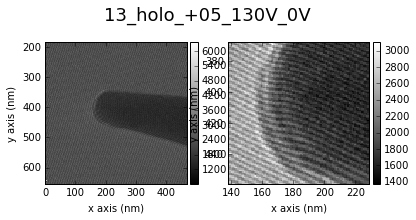

In [5]:
hs.plot.plot_images([holo0, holo0.isig[150:250, 200:300]], tight_layout=False)

Loading object hologram of the needle at 5V bias and vacuum reference

In [6]:
holo5 = hs.load('./datasets/02_holo_Vbp_130V_5V_bin2_crop.hdf5', signal_type='hologram')

In [7]:
ref = hs.load('./datasets/00_ref_Vbp_130V_0V_bin2_crop.hdf5', signal_type='hologram')

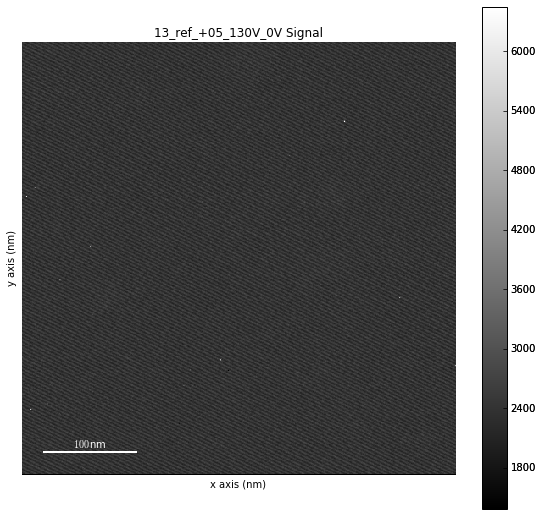

In [8]:
ref.plot()

# 2. Reconstructing holograms

Reconstruction of off-axis holograms involves finding a sideband in FFT patttern, filtering the sideband and re-centering FFT in the centre of the sideband, followed by inverse Fourier transform

First, onc may check how does FFT of a hologram looks like:

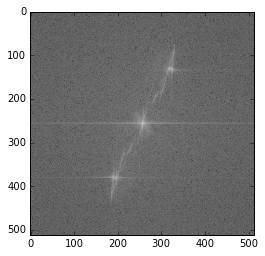

In [9]:
fft_holo0 = np.log(np.abs(fftshift(fft2(holo0.data))))
plt.imshow(fft_holo0)

One sees two sidebands in upper and lower parts of the FFT. Those correspond to two complex conjugate electron waves. Selecting one or another will only change sign of the reconstructed phase. The criteria for the selection is the convention that the phase shift inside material is positive with respect to vacuum. This can be checked only after the reconstruction, therefore the upper sideband is selected for the moment:

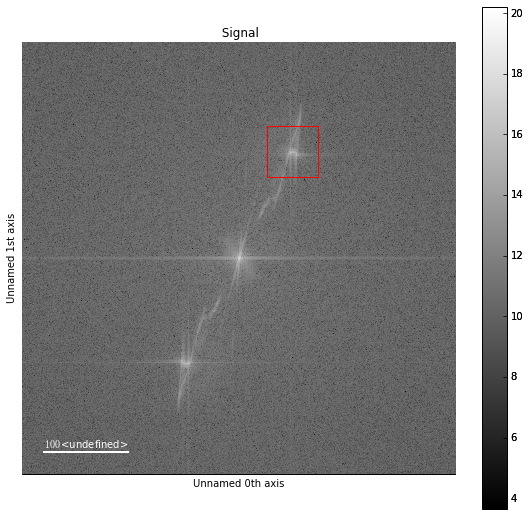

In [10]:
fft_holo0 = hs.signals.Signal2D(fft_holo0)
m = hs.plot.markers.rectangle(x1=290, y1=100, x2=350, y2=160, color='red')
fft_holo0.add_marker(m)

Prior to reconstruction the position of sideband centre and the radius of sideband filter have to be defined. To avoid artificial slopes in the reconstructed phase this has to be done using vacuum reference rather than object hologram:

In [11]:
sb_position = ref.estimate_sideband_position(sb='upper')
sb_position.data

array([390,  59])

The output is HyperSpy's Signal1D

_Note: The coordinates of sideband are given for non-shifted FFT, therefore there are differnt from above!_

In [12]:
sb_size = ref.estimate_sideband_size(sb_position)
sb_size.data

array([ 67.75876327])

By default sideband size is set to half a distance from sideband to origin and it is Signal1D class as well

Reconstructing both holograms with vacuum reference, setting output_shape to the size of the sideband filter to avoid oversampling:

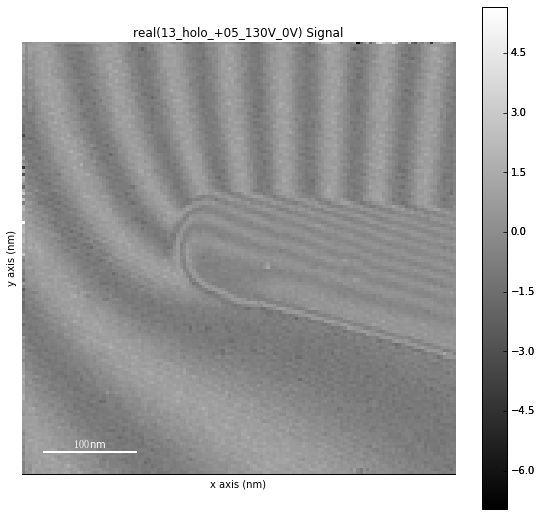

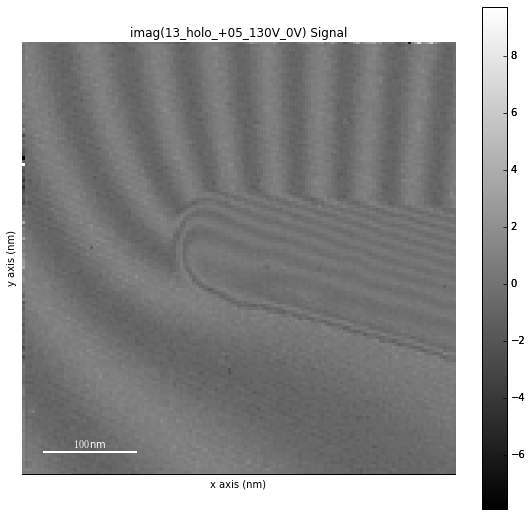

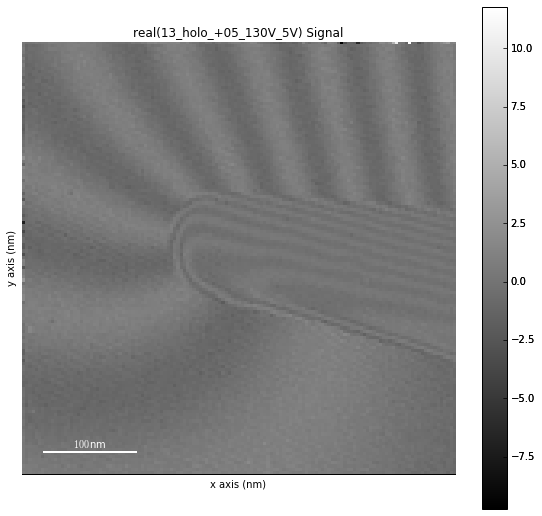

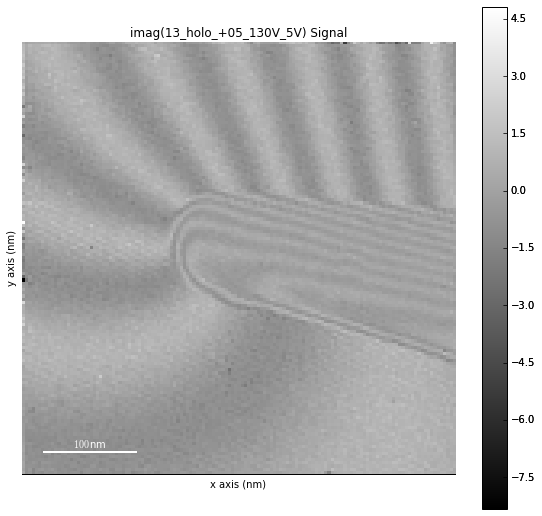

In [13]:
wave0 = holo0.reconstruct_phase(ref, sb_position=sb_position, sb_size=sb_size,
                                output_shape=(int(sb_size.data*2), int(sb_size.data*2)))
wave0.plot()
wave5 = holo5.reconstruct_phase(ref, sb_position=sb_position, sb_size=sb_size,
                                output_shape=(int(sb_size.data*2), int(sb_size.data*2)))
wave5.plot()

# 2. Accessing reconstructed phase, amplitude and unwrapping phase

Plotting amplitude of a reconstructed wave:

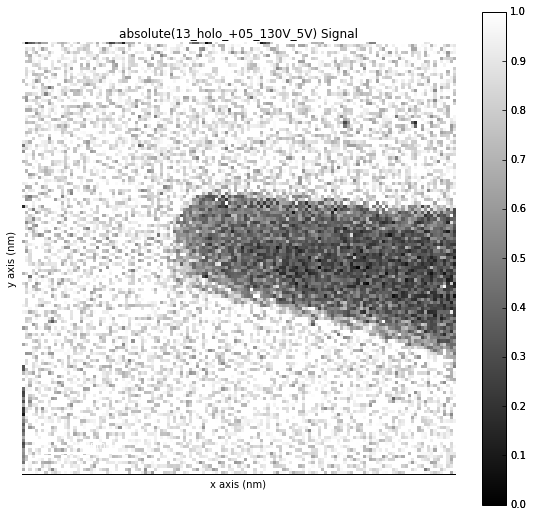

In [14]:
wave5.amplitude.plot(vmin=0, vmax=1)

Wrapped phase:

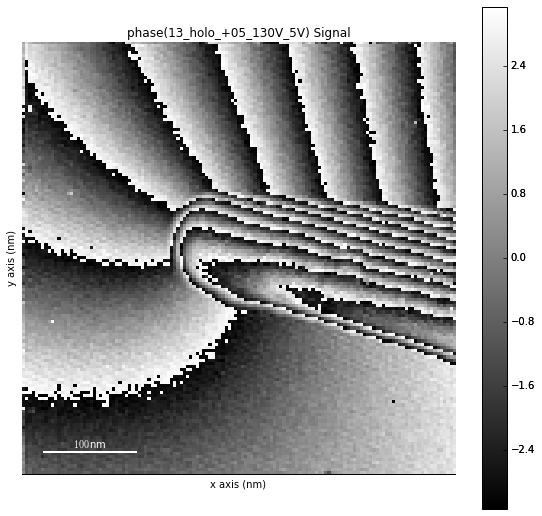

In [15]:
wave5.phase.plot()

Since phase changes between -Pi and PI, it possesse rapid jumps called phase wraps. The phase can be unwrapped as follows:

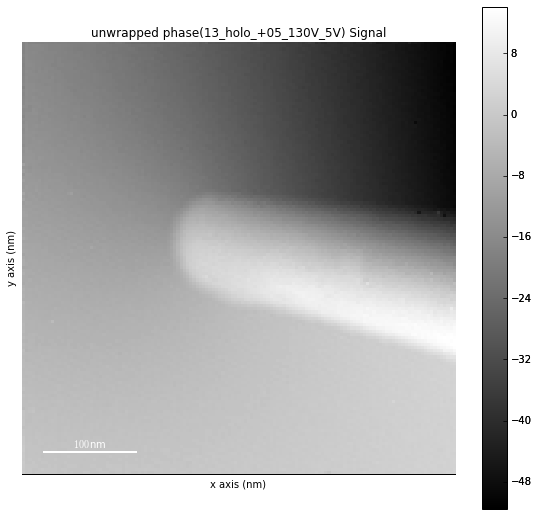

In [16]:
wave5.unwrapped_phase().plot()

One sees, that the phase shift inside material is positive, therefore the sideband was selected correctly.

# 3. Calculating phase shift due to external electrostatic field

The phase shift shown above includes three contributions:
1. Contribution of mean inner potential of needle itself;
2. Contribution of magnetic field, since needle's material is magnetic;
3. Contribution of external electrostatic field, since bias voltage of 5V was applied.

Since 1 and 2 are the same for both holograms, the 0V phase shift should be subtracted from 5V phase shift in order to access external electrostatic field contribution only.
Though, two factors have to be taken into account:
1. Missalignment of two holograms will cause artifacts. Therfore the images should be aligned prior to subtraction.
2. The subtraction of phase images directly may fail due to phase wraps in case of wrapped phase and due to phase offset in case of unwrapped phase. The best way to subtarct two phase images is to divide corresponding wave images. (These opperations are mathematically equivalent.)


Trying simple subtraction without alignment:

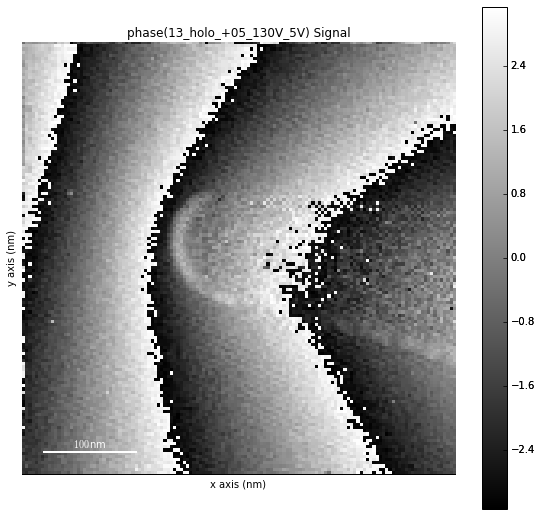

In [17]:
wave_electrostatic = wave5 / wave0
wave_electrostatic.phase.plot()

One sees the shadows around needle surface which is a clear indication for missalignment of the images. Aligning the images:

In [18]:
phase_stack = hs.stack([wave0.unwrapped_phase(), wave5.unwrapped_phase()])
shifts = phase_stack.estimate_shift2D()


/Users/vadim/anaconda/lib/python3.5/site-packages/scipy/fftpack/basic.py:153: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  z = zeros(s,x.dtype.char)


In [19]:
shifts

array([[ 0,  0],
       [ 0, -1]])

Typically alignment of holograms is not a trivial task. Different methods should be tried to achiev best results. Also a subpixel alignmnet is benifitial especially for the case when the size of reconstructed image set to the size of sideband filter. Here the improovmnet of automatic alignment is skept and images are aligned manualy by varying shifts untill best results were achieved istead.

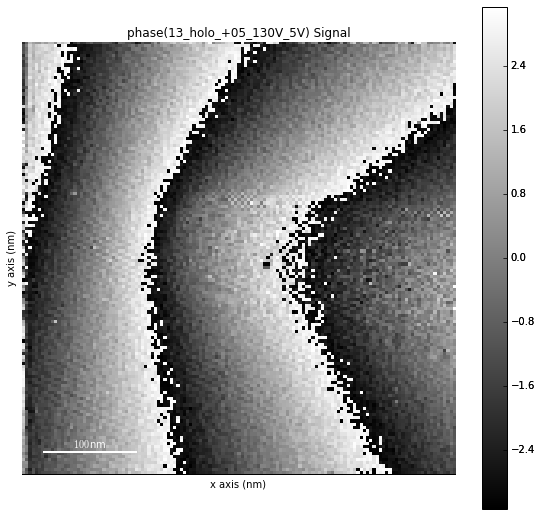

In [20]:
wave5a= wave5.deepcopy()
wave5a.map(np.roll, shift=0, axis=0)
wave5a.map(np.roll, shift=1, axis=1)

wave_electrostatic = wave5a / wave0
wave_electrostatic.phase.plot()

One can get unwrapped phase shift due to external electrostatic field:

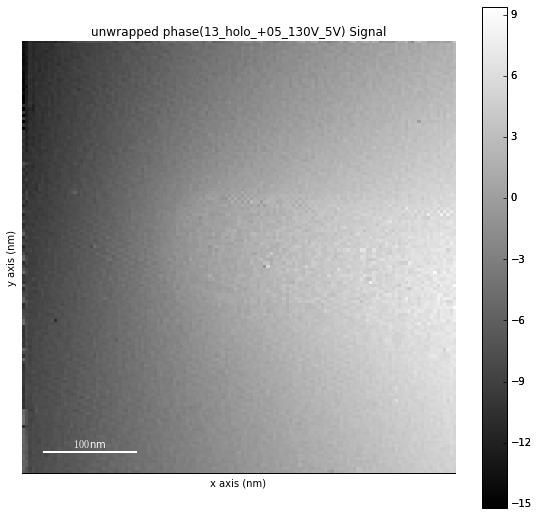

In [21]:
uphase_electrostatic = wave_electrostatic.unwrapped_phase()
uphase_electrostatic.plot()

Use a cosine function to plot equiphase contours which represent projected equipotential lines (here the cosine argument is multiplied with 2 that corresponds to contour separation of PI):

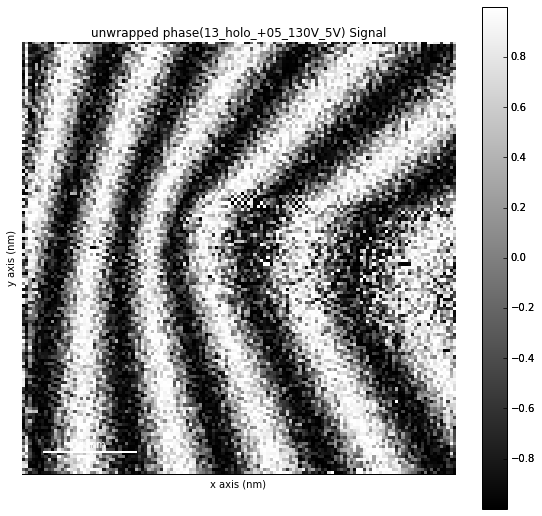

In [22]:
contours_electrostatic = uphase_electrostatic._deepcopy_with_new_data(np.cos(2*uphase_electrostatic.data))
contours_electrostatic.plot()

Signal __uphase_electrostatic__ can be used for further analyses of charge distribution using Laplacian or loop integration of phase gradient. The corresponding functions will be included in next releases